In [2]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

# Load libriaries and functions.
from tensorflow import keras
tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from scipy import stats
from patsy import dmatrices # helps format the input and target variables for ML

# import specific functions from the machine learning library, "sklearn"
from sklearn import svm, neighbors, tree
from sklearn.model_selection import RepeatedKFold, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# import seaborn as sns
# sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read data from the .csv file

df = pd.read_csv("am_measurement_data.csv")
df.head()

,print_serial,design,print_location,hardware,layout,material,color,feature_category,feature_class,feature_id,feature_category_class,material_color,part_id,print_x_mm,print_y_mm,CAD_mm,measure_mm,DFT_mm,print_dist_from_origin_mm,thermal_cure
0,KR70035C,bracket,7,1,1,EPX,black,center,dist_length,bracket_dist_mm_c,center_dist_length,EPX_black,KR70035C_7,42,48,15.0,14.969881,-0.030119,63.780875,True
1,KR70035C,bracket,7,1,1,EPX,black,height,height,bracket_height_mm,height_height,EPX_black,KR70035C_7,42,48,8.0,7.644579,-0.355421,63.780875,True
2,KR70035C,bracket,7,1,1,EPX,black,inner,dia,bracket_inner_dia_mm_a,inner_dia,EPX_black,KR70035C_7,42,48,2.5,2.404393,-0.095607,63.780875,True
3,KR70035C,bracket,7,1,1,EPX,black,inner,length,bracket_inner_length_mm_b,inner_length,EPX_black,KR70035C_7,42,48,15.0,14.928239,-0.071761,63.780875,True
4,KR70035C,bracket,7,1,1,EPX,black,outer,thick,bracket_thick_mm_a,outer_thick,EPX_black,KR70035C_7,42,48,2.0,1.995835,-0.004165,63.780875,True


In [4]:
# Define the target (y) variable and the input (x) variables
# Notice "dmatrices" one-hot-encodes categorical variables for us 

y, x = dmatrices('DFT_mm ~ CAD_mm + print_x_mm + print_y_mm + print_dist_from_origin_mm + C(material) + C(hardware) + C(feature_category) + C(feature_class)', df, return_type="dataframe")
y = y.astype(float)
x = x.astype(float)
y.head()    # target variable to be predicted

,DFT_mm
0,-0.030119
1,-0.355421
2,-0.095607
3,-0.071761
4,-0.004165


In [5]:
x.head()    # model inputs to predict y

,Intercept,C(material)[T.RPU],C(material)[T.UMA],C(hardware)[T.2],C(feature_category)[T.height],C(feature_category)[T.inner],C(feature_category)[T.outer],C(feature_class)[T.dist_length],C(feature_class)[T.height],C(feature_class)[T.length],C(feature_class)[T.rad_thick],C(feature_class)[T.thick],CAD_mm,print_x_mm,print_y_mm,print_dist_from_origin_mm
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15.0,42.0,48.0,63.780875
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,42.0,48.0,63.780875
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,42.0,48.0,63.780875
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,15.0,42.0,48.0,63.780875
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,42.0,48.0,63.780875


In [6]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state = 2022)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state= 2022) # 0.25 x 0.8 = 0.2


print("x_train shape: {}".format(x_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("x_val shape: {}".format(x_val.shape))
print("y val shape: {}".format(y_val.shape))

x_train shape: (1215, 16)
x_test shape: (405, 16)
y_train shape: (1215, 1)
y_test shape: (405, 1)
x_val shape: (405, 16)
y val shape: (405, 1)


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
mc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

In [8]:
x_train

array([[ 0.   ,  1.373, -1.1  , ...,  0.748,  0.727, -0.471],
       [ 0.   , -0.728, -1.1  , ..., -1.571,  0.727,  1.185],
       [ 0.   ,  1.373, -1.1  , ..., -1.185, -1.41 ,  0.839],
       ...,
       [ 0.   ,  1.373, -1.1  , ...,  0.361,  0.727, -1.171],
       [ 0.   , -0.728,  0.909, ..., -1.571, -1.41 ,  1.584],
       [ 0.   , -0.728,  0.909, ...,  0.748,  1.439,  0.184]])

In [10]:
# Architecture for Bayesian Neural Network (BNN)
# Gives a deterministic output

n_epochs = 20000

# # Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(1, dtype=tf.float32), scale=1.0), reinterpreted_batch_ndims=1)

# Define model instance.
model_bnn = tfk.Sequential([tfk.layers.InputLayer(input_shape=(16,), name="input"),
tfk.layers.Dense(24, activation="relu", name="dense_1"),
tfk.layers.BatchNormalization(),
tfk.layers.Dense(16, activation="relu", name="dense_2"),
tfk.layers.BatchNormalization(),
tfk.layers.Dense(8, activation="relu", name="dense_3"),
tfk.layers.BatchNormalization(),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(1), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(1, 
                                  activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/len(x_train)), 
                                  name="output")], name="model")

neg_log_likelihood = lambda y, rv_y: -rv_y.log_prob(y)

# Compile model.
model_bnn.compile(optimizer="adam", loss=neg_log_likelihood, metrics=[keras.metrics.RootMeanSquaredError()])

In [11]:
import os

checkpoint_path = "saved_model_bnn/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [16]:

print("BNN model training started...")

history_bnn = model_bnn.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_val, y_val), callbacks=[cp_callback], verbose=0)

print("BNN model training finished.")


In [1]:
## Evaluating the performance of the trained BNN model ##

print("Evaluating BNN model performance...")

_, rmse = model_bnn.evaluate(x_train, y_train, verbose=0)
print(f"Train RMSE: {round(rmse, 3)}")
    
_, rmse = model_bnn.evaluate(x_test, y_test, verbose=0)
print(f"Test RMSE: {round(rmse, 3)}")

In [12]:
# Model evaluation using the saved weights from checkpoints after loading

# Loads the weights
model_bnn.load_weights(checkpoint_path)

print("Evaluating BNN model performance after loading weights from checkpoints...")

_, rmse = model_bnn.evaluate(x_train, y_train, verbose=0)
print(f"Train RMSE: {round(rmse, 3)}")

_, rmse = model_bnn.evaluate(x_test, y_test, verbose=0)
print(f"Test RMSE: {round(rmse, 3)}")

Evaluating BNN model performance after loading weights from checkpoints...
Train RMSE: 0.074
Test RMSE: 0.081


In [13]:
mean_preds_au=model_bnn(x_test).mean().numpy()
std_preds_au=model_bnn(x_test).stddev().numpy()

mean_preds_au = np.array(mean_preds_au).reshape(1, 405*1)

std_preds_au = np.array(std_preds_au).reshape(1, 405*1)
aleatoric_uncertainty = np.mean(std_preds_au)

y_test = np.array(y_test).flatten()
std_preds_au = np.array(std_preds_au).flatten()
mean_preds_au = np.array(mean_preds_au).flatten()

samples = 50
prediction_test = []
actual_test = []
aleatoric_CI = []

for idx in range(samples):
    prediction_test.append(round(mean_preds_au[idx], 4))
    actual_test.append(round(y_test[idx], 4))
    aleatoric_CI.append(round(std_preds_au[idx], 4))

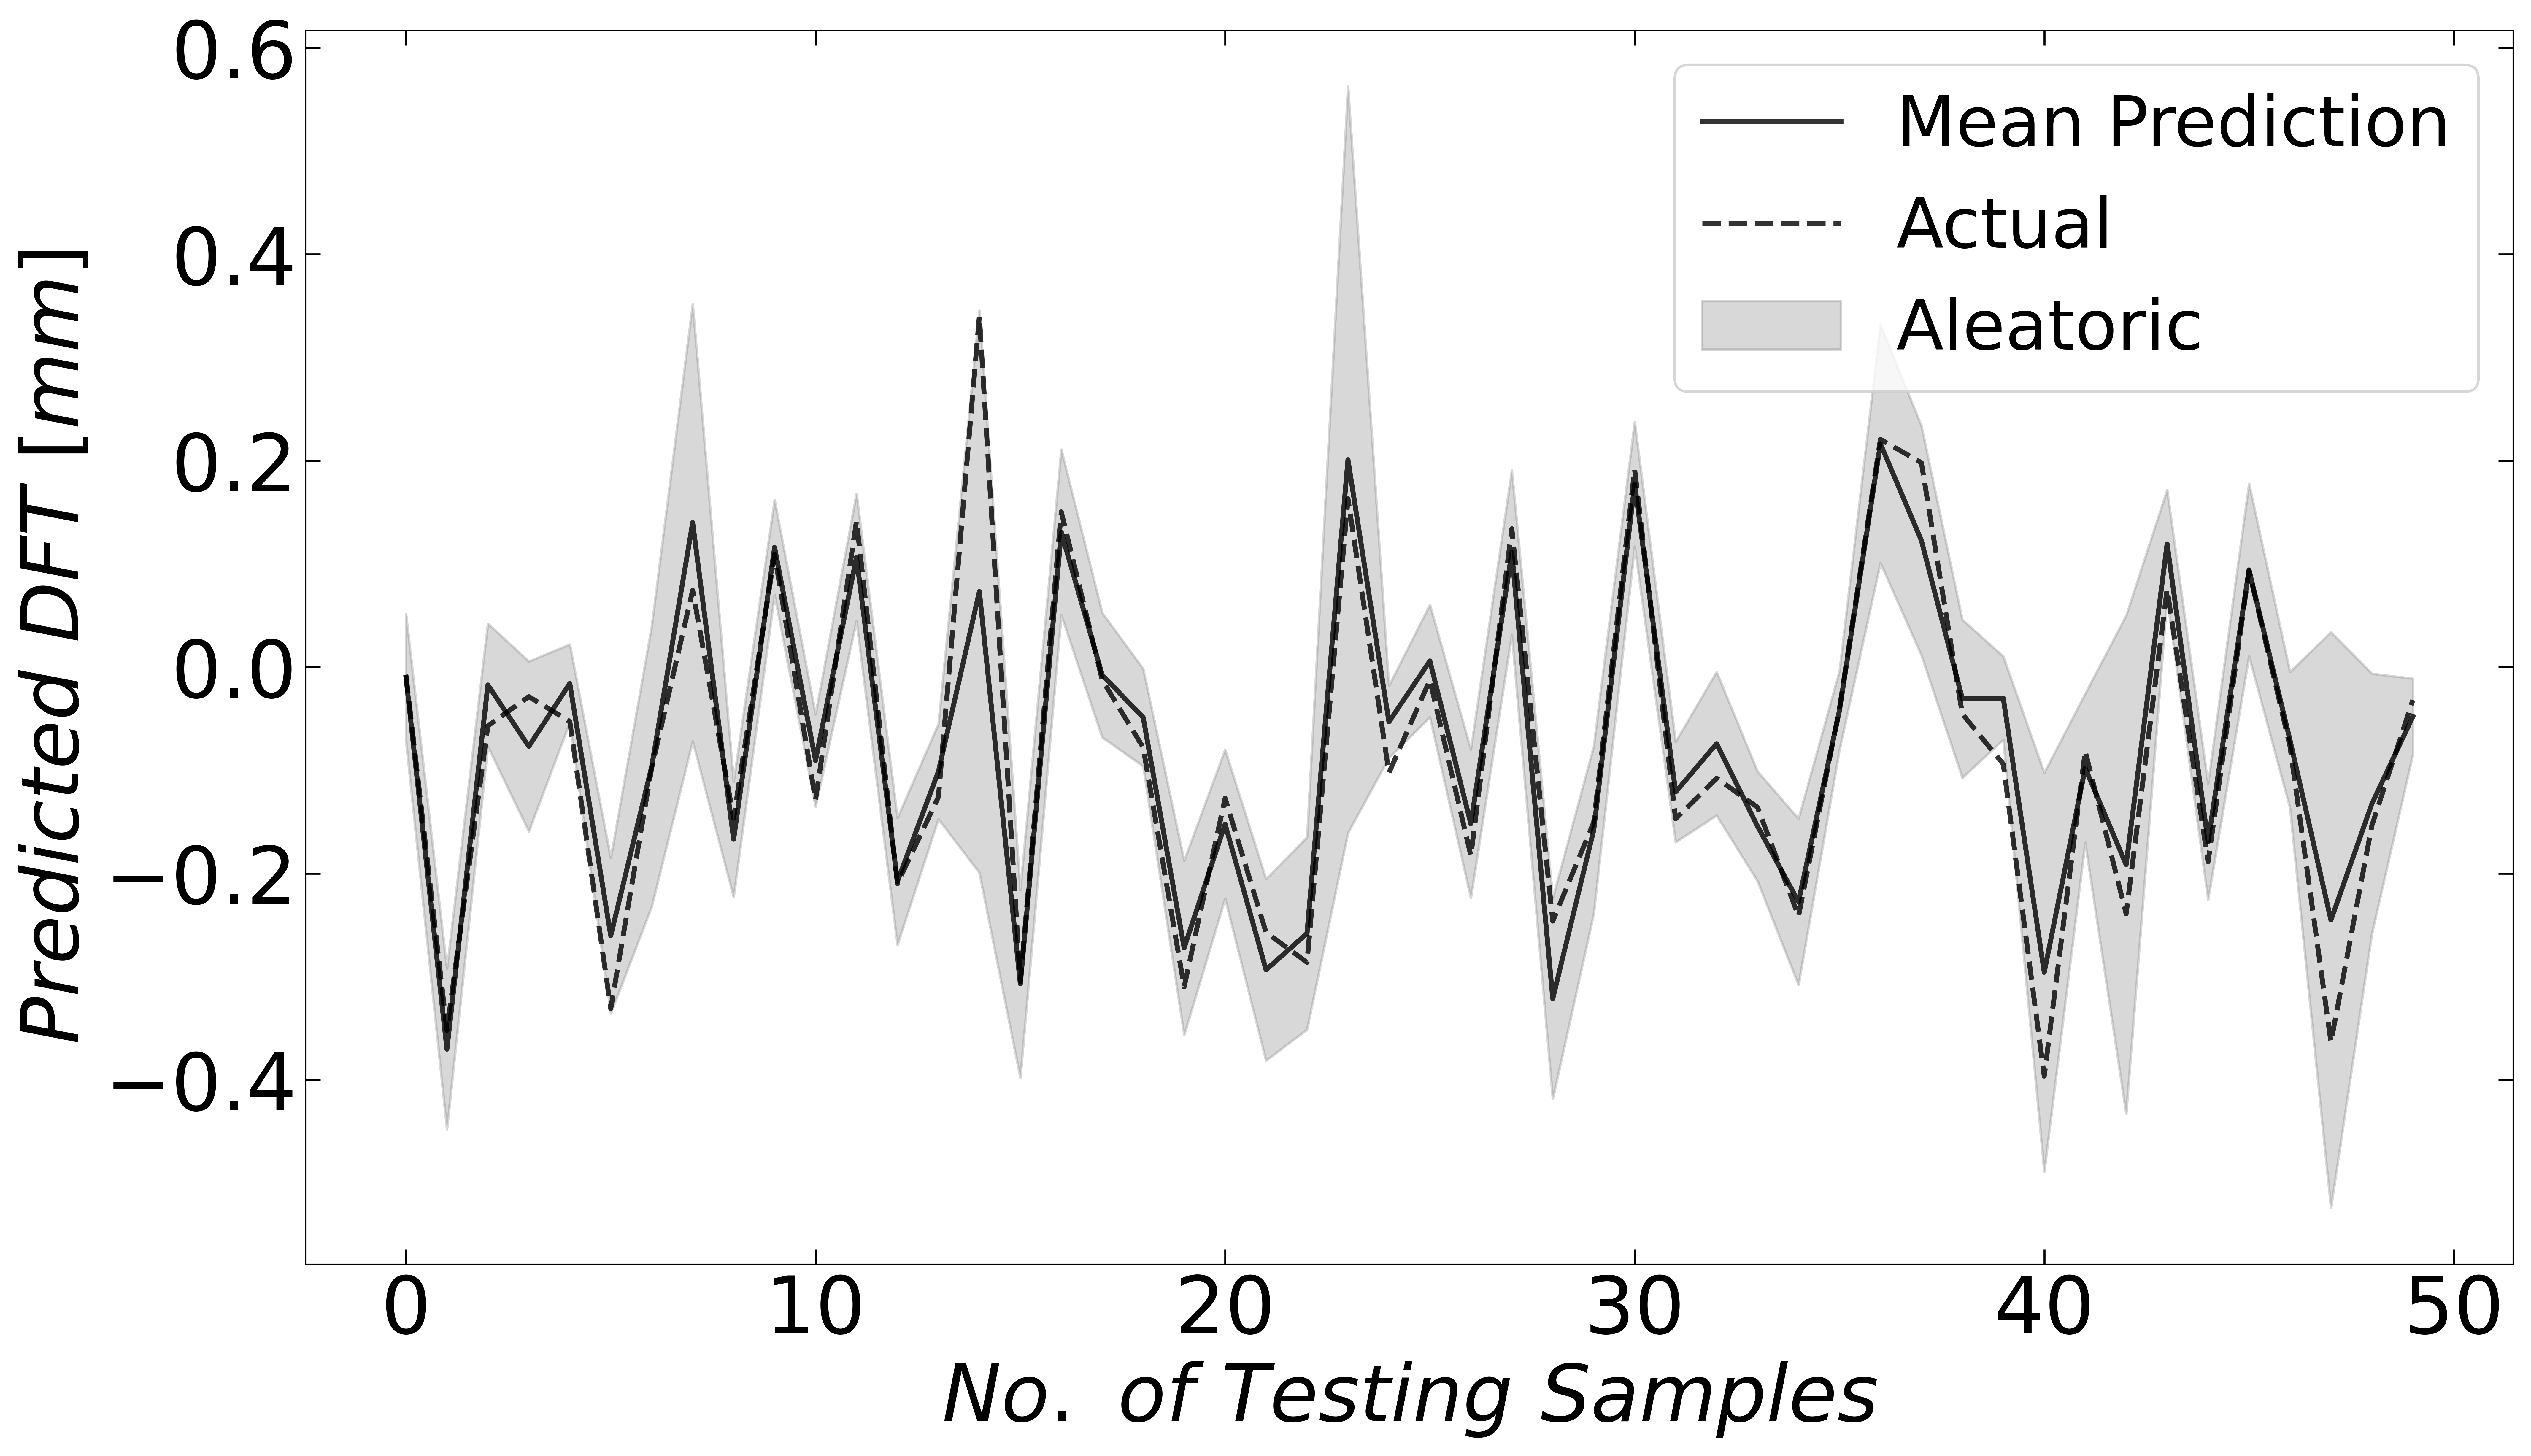

In [14]:
from matplotlib import rc
from matplotlib import rcParams

fontsize = 32
plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize) 
rc('ytick', labelsize=fontsize) 
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

fig, ((ax)) = plt.subplots(ncols=1, nrows=1, figsize=(16,9), dpi=600)

fontsize = 32
plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize) 
rc('ytick', labelsize=fontsize) 
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5


## -----------------------------------------------------------------------------------------------------------------------------------------------------

# Parity plot for PBNN (quantification of both aleatoric and epistemic uncertainty)

# ax.set_ylim(-0.5, 0.5)
# ax.set_xlim(-0.5, 0.5)

# # 1:1 line for perfect predictions
# x0, x1 = ax.get_xlim()
# y0, y1 = ax.get_ylim()
# lims = [max(x0, y0), min(x1, y1)]
# ax.plot(lims, lims, '--k', linewidth=5, alpha=0.2)

# ax.scatter(np.array(actual_test),np.array(prediction_test), s=60, facecolors='none', edgecolors='b', alpha=0.6, label='Mean Predictions')
# ax.errorbar(np.array(actual_test), np.array(prediction_test), yerr=aleatoric_CI, fmt='none', color='red', alpha=0.5, capsize=5, label='Aleatoric')

#-------------------- Line Plot for mean prediction and actual using PBNN -------------------------------------------------------------------------------

# x_grid = np.linspace(0, 49, 50)

# ax.plot(prediction_test[0:50], linestyle='solid', alpha=0.8, color='black', linewidth=2, label='Mean Prediction')
# ax.plot(actual_test[0:50], linestyle='dashed', alpha=0.8, color='black', linewidth=2, label='Actual')
# ax.fill_between(x_grid, prediction_test[0:50] + 1.96*np.array(aleatoric_CI[0:50]), prediction_test[0:50] - 1.96*np.array(aleatoric_CI[0:50]), alpha=0.3, 
#                  color='gray', label='Aleatoric')
# ax.fill_between(x_grid, prediction_test[0:50] + 1.96*np.array(epistemic_CI[0:50]), prediction_test[0:50] - 1.96*np.array(epistemic_CI[0:50]), alpha=0.4, 
#                  color='gray', label='Epistemic')

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fontsize=28)

## -----------------------------------------------------------------------------------------------------------------------------------------------------

# ax.set_ylabel(r'$Aleatoric$ $Uncertainty$ $[µm]$', fontweight ='bold', fontsize=fontsize)
# ax.set_xlabel(r'$Sampling$ $Fraction$ (% $Train$)', fontweight ='bold', fontsize=fontsize)

# ax.set_ylabel(r'$Uncertainty$ $[mm]$', fontweight ='bold', fontsize=fontsize)
# ax.set_xlabel(r'$Sampling$ $Fraction$ (% $Train$)', fontweight ='bold', fontsize=fontsize)

# ax.set_ylabel(r'$DFT$ $Values$ $[mm]$', fontweight ='bold', fontsize=fontsize)
ax.set_xlabel(r'$No.$ $of$ $Testing$ $Samples$', fontweight ='bold', fontsize=fontsize)

ax.set_ylabel(r'$Predicted$ $DFT$ $[mm]$', fontweight ='bold', fontsize=fontsize)
# ax.set_xlabel(r'$Measured$ $DFT$ $[mm]$', fontweight ='bold', fontsize=fontsize)

ax.tick_params(left = True, right = True, top= True, bottom= True, which = 'both')
ax.legend(loc='best', fontsize=28)
plt.savefig("Plots/Line_plot_UQ_BNN.png")

plt.show()